# Relation Extraction from Tables

This notebook demonstrates the full extraction and learning process for _relations_ in tables with a data set of transistor spec sheets, extracting (temperature label, min storage temperature) pairs. (Eventually, this tutorial will be updated to extract (part number, min storage temperature) pairs.

In [78]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cPickle, os, sys
np.random.seed(seed=1701)
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extraction

Use this option if you would like to unpickle a previously parsed corpus, (i.e., the corpus from the Entity Extraction notebook).

In [81]:
load_pickle = False
corpus_loaded = False

if load_pickle:
    try:
        import cPickle
        with open("data/hardware/hardware_corpus.pkl","r") as pkl:
            %time corpus = cPickle.load(pkl)
        corpus_loaded = True
        print "Corpus has been loaded."
    except:
        print "Corpus could not be loaded."
        print "Corpus will be parsed instead..."
if not corpus_loaded:
    from snorkel.parser import CorpusParser
    from snorkel.parser import HTMLParser
    from snorkel.parser import TableParser

    html_parser = HTMLParser(path='data/hardware/hardware_html/')
    table_parser = TableParser()

    cp = CorpusParser(html_parser, table_parser, max_docs=30)
    %time corpus = cp.parse_corpus(name='Hardware Corpus')
    print "Corpus has been parsed."

CPU times: user 15.6 s, sys: 348 ms, total: 15.9 s
Wall time: 30.2 s
Corpus has been parsed.


We now create two EntityExtractor objects, one for each component in the relation.

In [82]:
from snorkel.candidates import TableNgrams, EntityExtractor, RelationExtractor
from snorkel.matchers import RegexMatchEach, DictionaryMatch, RangeMatcher
from load_dictionaries import load_hardware_dictionary

# Select a CandidateSpace
table_ngrams = TableNgrams(n_max=2)

# Entity Extractor 1: Part numbers
parts = load_hardware_dictionary()
print "Loaded %s part numbers." % len(parts)

# NOTE: this will not catch items in ranges (e.g., BC546-BC548) or lists (e.g., BC546/547/548)
part_matcher = DictionaryMatch(d=parts, longest_match_only=False)
part_extractor = EntityExtractor(table_ngrams, part_matcher)

# Entity Extractor 2: Temperatures (min storage temperature)
# temp_matcher = RangeMatcher(low=140,high=160)
temp_matcher = RegexMatchEach(rgx=r'1[3-7][05]', attrib='words')
temp_extractor = EntityExtractor(table_ngrams, temp_matcher)

# Relation Extractor:
relation_extractor = RelationExtractor(part_extractor, temp_extractor)

Loaded 179 part numbers.


In [83]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
ngrams = TableNgrams(n_max=2)

# Define a matcher
# number_matcher = RangeMatcher(low=-70,high=-50)
temp_matcher = RegexMatchEach(rgx=r'1[3-7][05]', attrib='words')
from snorkel.candidates import EntityExtractor
ce = EntityExtractor(ngrams, temp_matcher)
%time candidates = ce.extract(corpus.get_tables(), name='all')
for cand in candidates[:10]: 
    print cand
print "%s candidates extracted" % len(candidates)

CPU times: user 1.24 s, sys: 15 ms, total: 1.25 s
Wall time: 1.26 s
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[4,6], words=[2,2])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[7,9], words=[3,3])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
150 candidates extracted


In [84]:
# %time candidates = temp_extractor.extract(corpus.get_tables(), name='all')
%time candidates = relation_extractor.extract(corpus.get_tables(), name='all')

for cand in candidates[:10]: 
    print cand
print "%s part numbers extracted" % len(candidates)

CPU times: user 4.69 s, sys: 57.3 ms, total: 4.75 s
Wall time: 4.78 s
SpanPair(Span("BC546", context=None, chars=[122,126], words=[24,24]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC546", context=None, chars=[122,126], words=[24,24]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC546", context=None, chars=[122,126], words=[24,24]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC547", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC547", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC547", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC548", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC548", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, cha

In [85]:
from utils import collect_hardware_relation_gold
filename = 'data/hardware/gold_all.csv'
gt_dict = collect_hardware_relation_gold(filename, 'stg_temp_max', candidates)
print "%s out of %s candidates have gold labels" % (len(gt_dict),len(candidates))
print "%s out of %s labeled candidates have positive label" \
        % (gt_dict.values().count(1), len(gt_dict))

179 gold annotations available
353 out of 353 candidates have gold labels
305 out of 353 labeled candidates have positive label


In [100]:
from snorkel.features import TableNgramPairFeaturizer
featurizer = TableNgramPairFeaturizer()
featurizer.fit_transform(candidates)
for f in featurizer.get_features_by_candidate(candidates[0])[:10]: print f

e0_DDLIB_WORD_SEQ_[BC546]
e0_DDLIB_LEMMA_SEQ_[bc546]
e0_DDLIB_POS_SEQ_[NN]
e0_DDLIB_DEP_SEQ_[appos]
e0_DDLIB_W_LEFT_1_[-rrb-]
e0_DDLIB_W_LEFT_POS_1_[-RRB-]
e0_DDLIB_W_LEFT_2_[mhz -rrb-]
e0_DDLIB_W_LEFT_POS_2_[NN -RRB-]
e0_DDLIB_W_LEFT_3_[_NUMBER mhz -rrb-]
e0_DDLIB_W_LEFT_POS_3_[CD NN -RRB-]


In [87]:
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    if c.uid in gt_dict:
        gold_candidates.append(c)
        gold_labels.append(gt_dict[c.uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==-1])

Training set size: 177
Gold set size: 176
Positive labels in gold set: 165
Negative labels in gold set: 11


In [88]:
# Part number LFs
# TODO

# Temperature LFs
def LF_to_range(m):
    return 1 if 'to' in m.span1.pre_window('words') else 0
def LF_tilde_range(m):
    return 1 if '~' in m.span1.pre_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.span1.aligned_ngrams('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.span1.aligned_ngrams('words') else -1
def LF_tj(m):
    return 1 if 'tj' in m.span1.aligned_ngrams('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.span1.aligned_ngrams('words') else -1
def LF_celsius(m):
    return 1 if 'c' in m.span1.aligned_ngrams('words') else 0
def LF_max(m):
    return 1 if 'max' in m.span1.aligned_ngrams('lemmas') else 0
def LF_min(m):
    return 1 if 'min' in m.span1.aligned_ngrams('lemmas') else 0

# Combined LFs
def LF_same_row(m):
    return 1 if m.span0.context.row_num == m.span1.context.row_num else 0
def LF_same_col(m):
    return 1 if m.span0.context.col_num == m.span1.context.col_num else 0

# NOTE: don't forget to add LF name to LFs below

In [89]:
LFs = [LF_to_range, LF_tilde_range, LF_storage, LF_tstg, LF_tj, LF_temperature, 
       LF_max, LF_min, LF_same_row, LF_same_col]

In [90]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LFs, featurizer=TableNgramPairFeaturizer())

Applying LFs...
Featurizing...
LF Summary Statistics: 10 LFs applied to 177 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		58.19%
Overlap (candidates w/ > 1 labels):		100.00%
Conflict (candidates w/ conflicting labels):	85.31%


In [91]:
lf_stats = training_set.lf_stats()
lf_stats[:5]

,conflicts,coverage,j,overlaps
LF_to_range,0.000000,0,0,0
LF_tilde_range,0.000000,0,1,0
LF_storage,0.853107,1,2,1
LF_tstg,0.853107,1,3,1
LF_tj,0.853107,1,4,1


array([[<matplotlib.axes.AxesSubplot object at 0x110851d50>]], dtype=object)

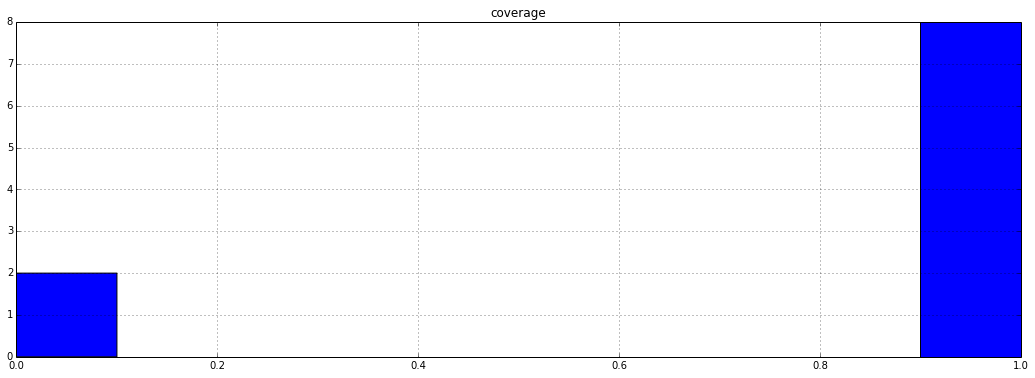

In [92]:
lf_stats.hist("coverage")

In [93]:
from snorkel.snorkel import Learner
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg(bias_term=True))

In [94]:
# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

In [95]:
from snorkel.learning_utils import GridSearch

gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.076860
	Learning epoch = 250	Gradient mag. = 0.129642
	Learning epoch = 500	Gradient mag. = 0.132638
	Learning epoch = 750	Gradient mag. = 0.146891
Final gradient magnitude for rate=0.01, mu=1e-05: 0.173
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.122700
	Learning epoch = 250	Gradient mag. = 0.129608
	Learning epoch = 500	Gradient mag. = 0.132387
	Learning epoch = 750	Gradient mag. = 0.145472
Final gradient magnitude for rate=0.01, mu=1e-05: 0.172
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.076860
	Learning epoch = 250	Gradient mag. = 0.129667
	Learning epoch = 500	Gradient mag. = 0.132833
	Learning epoch = 750	Gradient mag. = 0.147808
Final gradient magnitude for rate=0.01, mu=1e-07: 0.173
Testin

In [96]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.875,1,0.933333
1,0.00001,2,0.875,1,0.933333
2,0.00000,1,0.875,1,0.933333
3,0.00000,2,0.875,1,0.933333


Applying LFs...
Featurizing...


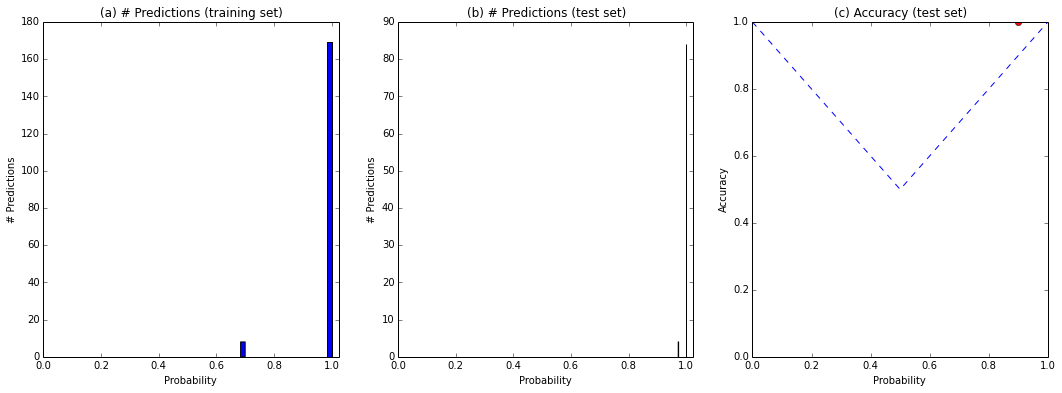

Test set size:	88
----------------------------------------
Precision:	1.0
Recall:		1.0
F1 Score:	1.0
----------------------------------------
TP: 88 | FP: 0 | TN: 0 | FN: 0


In [97]:
learner.test(test_candidates, test_labels)

In [104]:
learner.feature_stats(n_max=10)

,j,w
e0_TABLE_ROW_WORDS_ratings,2895,0.038779
e0_TABLE_COL_WORDS_vbe_-lrb-_on,621,0.038779
e1_TABLE_COL_WORDS_=_10_\,2699,0.038779
e0_TABLE_ROW_WORDS_ic_=_10,2704,0.038779
e1_TABLE_ROW_WORDS_100ma,2707,0.038779
e0_TABLE_ROW_WORDS_otherwise,2712,0.038779
e0_TABLE_COL_WORDS_ib_=,218,0.038779
e0_TABLE_COL_WORDS_-rrb-_collector-base_voltage,2714,0.038779
e1_TABLE_ROW_WORDS_storage_junction,2720,0.038779
e1_TABLE_COL_WORDS_on_-rrb-,2726,0.038779
